In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date'] = df.event_date.apply(date_converter)

In [3]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


In [4]:
df.event_date.max()

Timestamp('2019-12-09 00:00:00')

In [5]:
df.revenue_amount.describe()

count    8.625842e+06
mean     4.009047e+02
std      9.602217e+02
min      1.000000e+00
25%      8.800000e+01
50%      1.670000e+02
75%      4.050000e+02
max      2.881230e+05
Name: revenue_amount, dtype: float64

In [6]:
df.user_segment.unique()

array([4626944681007198896, 2376074197230840906,  853431062533847667],
      dtype=int64)

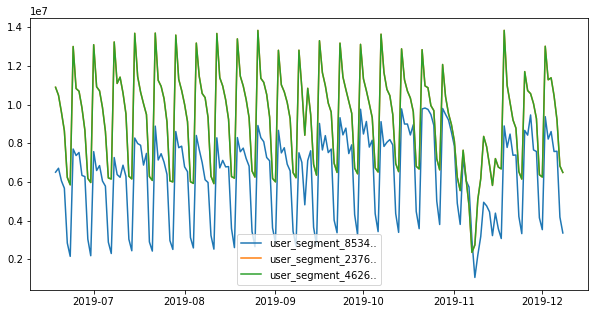

In [7]:
user_segment   = df.groupby(by=['event_date', 'user_segment']).sum()['revenue_amount'].reset_index('user_segment')
revenue_user_segment_1 = user_segment[user_segment.user_segment == 853431062533847667]['revenue_amount']
revenue_user_segment_2 = user_segment[user_segment.user_segment == 2376074197230840906]['revenue_amount']
revenue_user_segment_3 = user_segment[user_segment.user_segment == 4626944681007198896]['revenue_amount']
plt.figure(figsize=(10, 5))
plt.plot(revenue_user_segment_1, label='user_segment_8534..')
plt.plot(revenue_user_segment_2, label='user_segment_2376..')
plt.plot(revenue_user_segment_2, label='user_segment_4626..')
plt.legend()
plt.show()

In [8]:
df.category.unique()

array([7204754148424990691,   57514010642945023, 5983323600580891431,
       6847326422676498281, 3187769798308634693, 1472231361867825698,
       1793067034829450750, 2923341857645916506, 7948270325129383019,
         91460430793700892,  264558924403680107, 4394253463123676325,
       7247164925237372155, 3429514168013826643, 4546178272531746227,
       5284347926600386297, 6549025562984299367, 2965866302161963961,
       6864443610550051939,  282115902545472456, 4658595883120885993,
       3619272498251215842, 6742557862815872936, 1560592244484430230,
       4409084324312788296, 3358911609809004109, 2343719193625129042,
       5736208844128861898,  174490086998335078,  320230973495659885,
       5387097547938806535, 7164285449278522823, 5858189596811644833],
      dtype=int64)

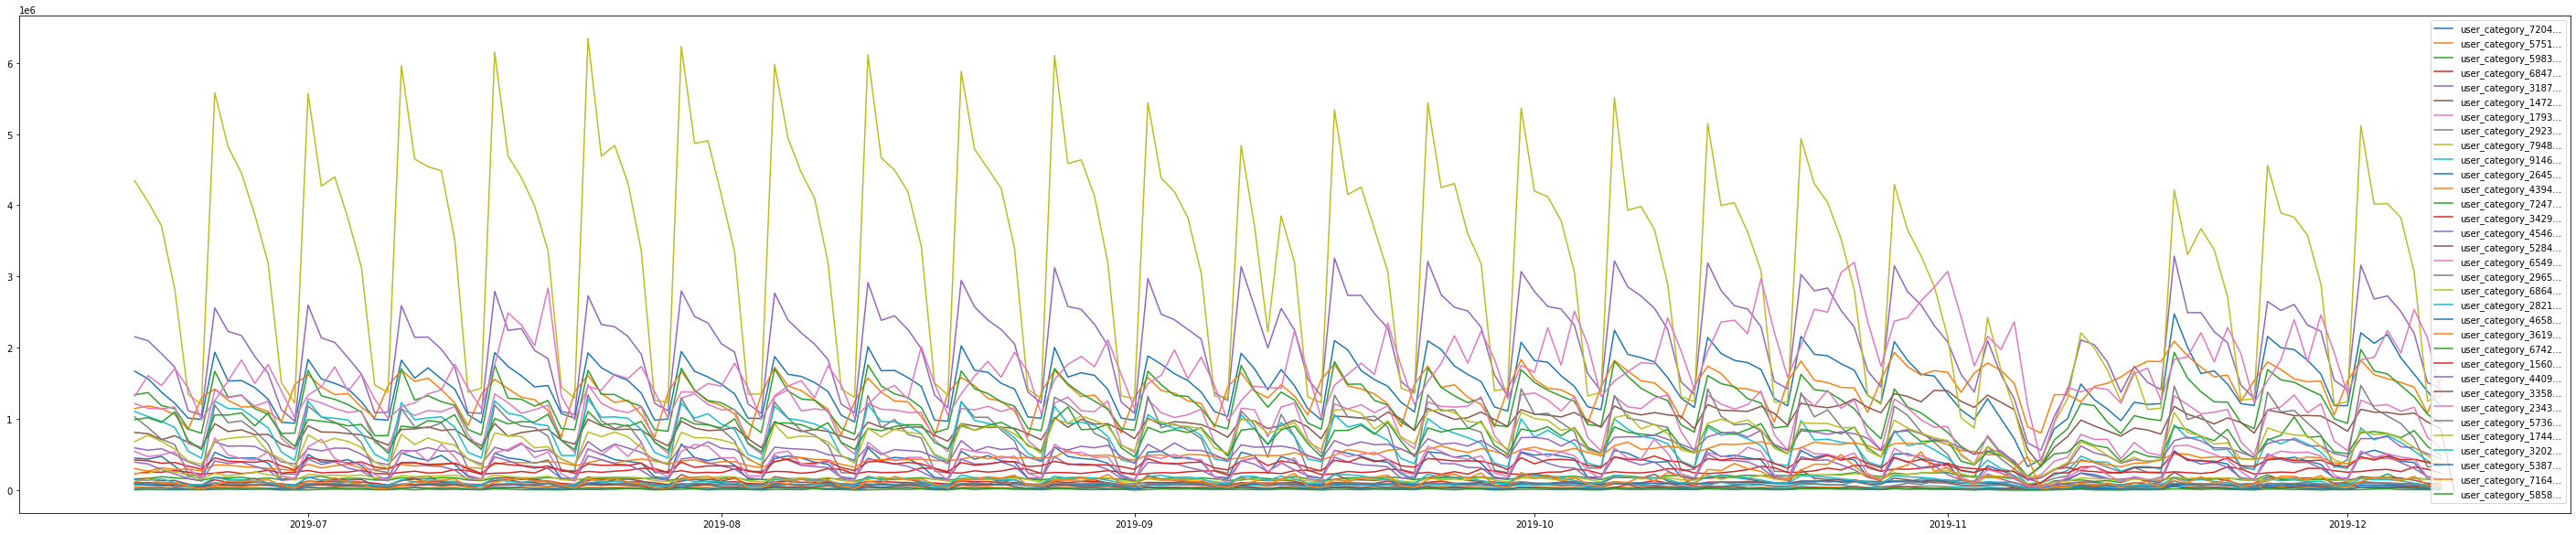

In [9]:
user_category = df.groupby(by=['event_date', 'category']).sum()['revenue_amount'].reset_index('category')

plt.figure(figsize=(50, 10))
for id_category in df.category.unique():
    revenue_category = user_category[user_category.category == id_category]['revenue_amount']
    plt.plot(revenue_category, label=f'user_category_{str(id_category)[:4]}...')
plt.legend()
plt.show()

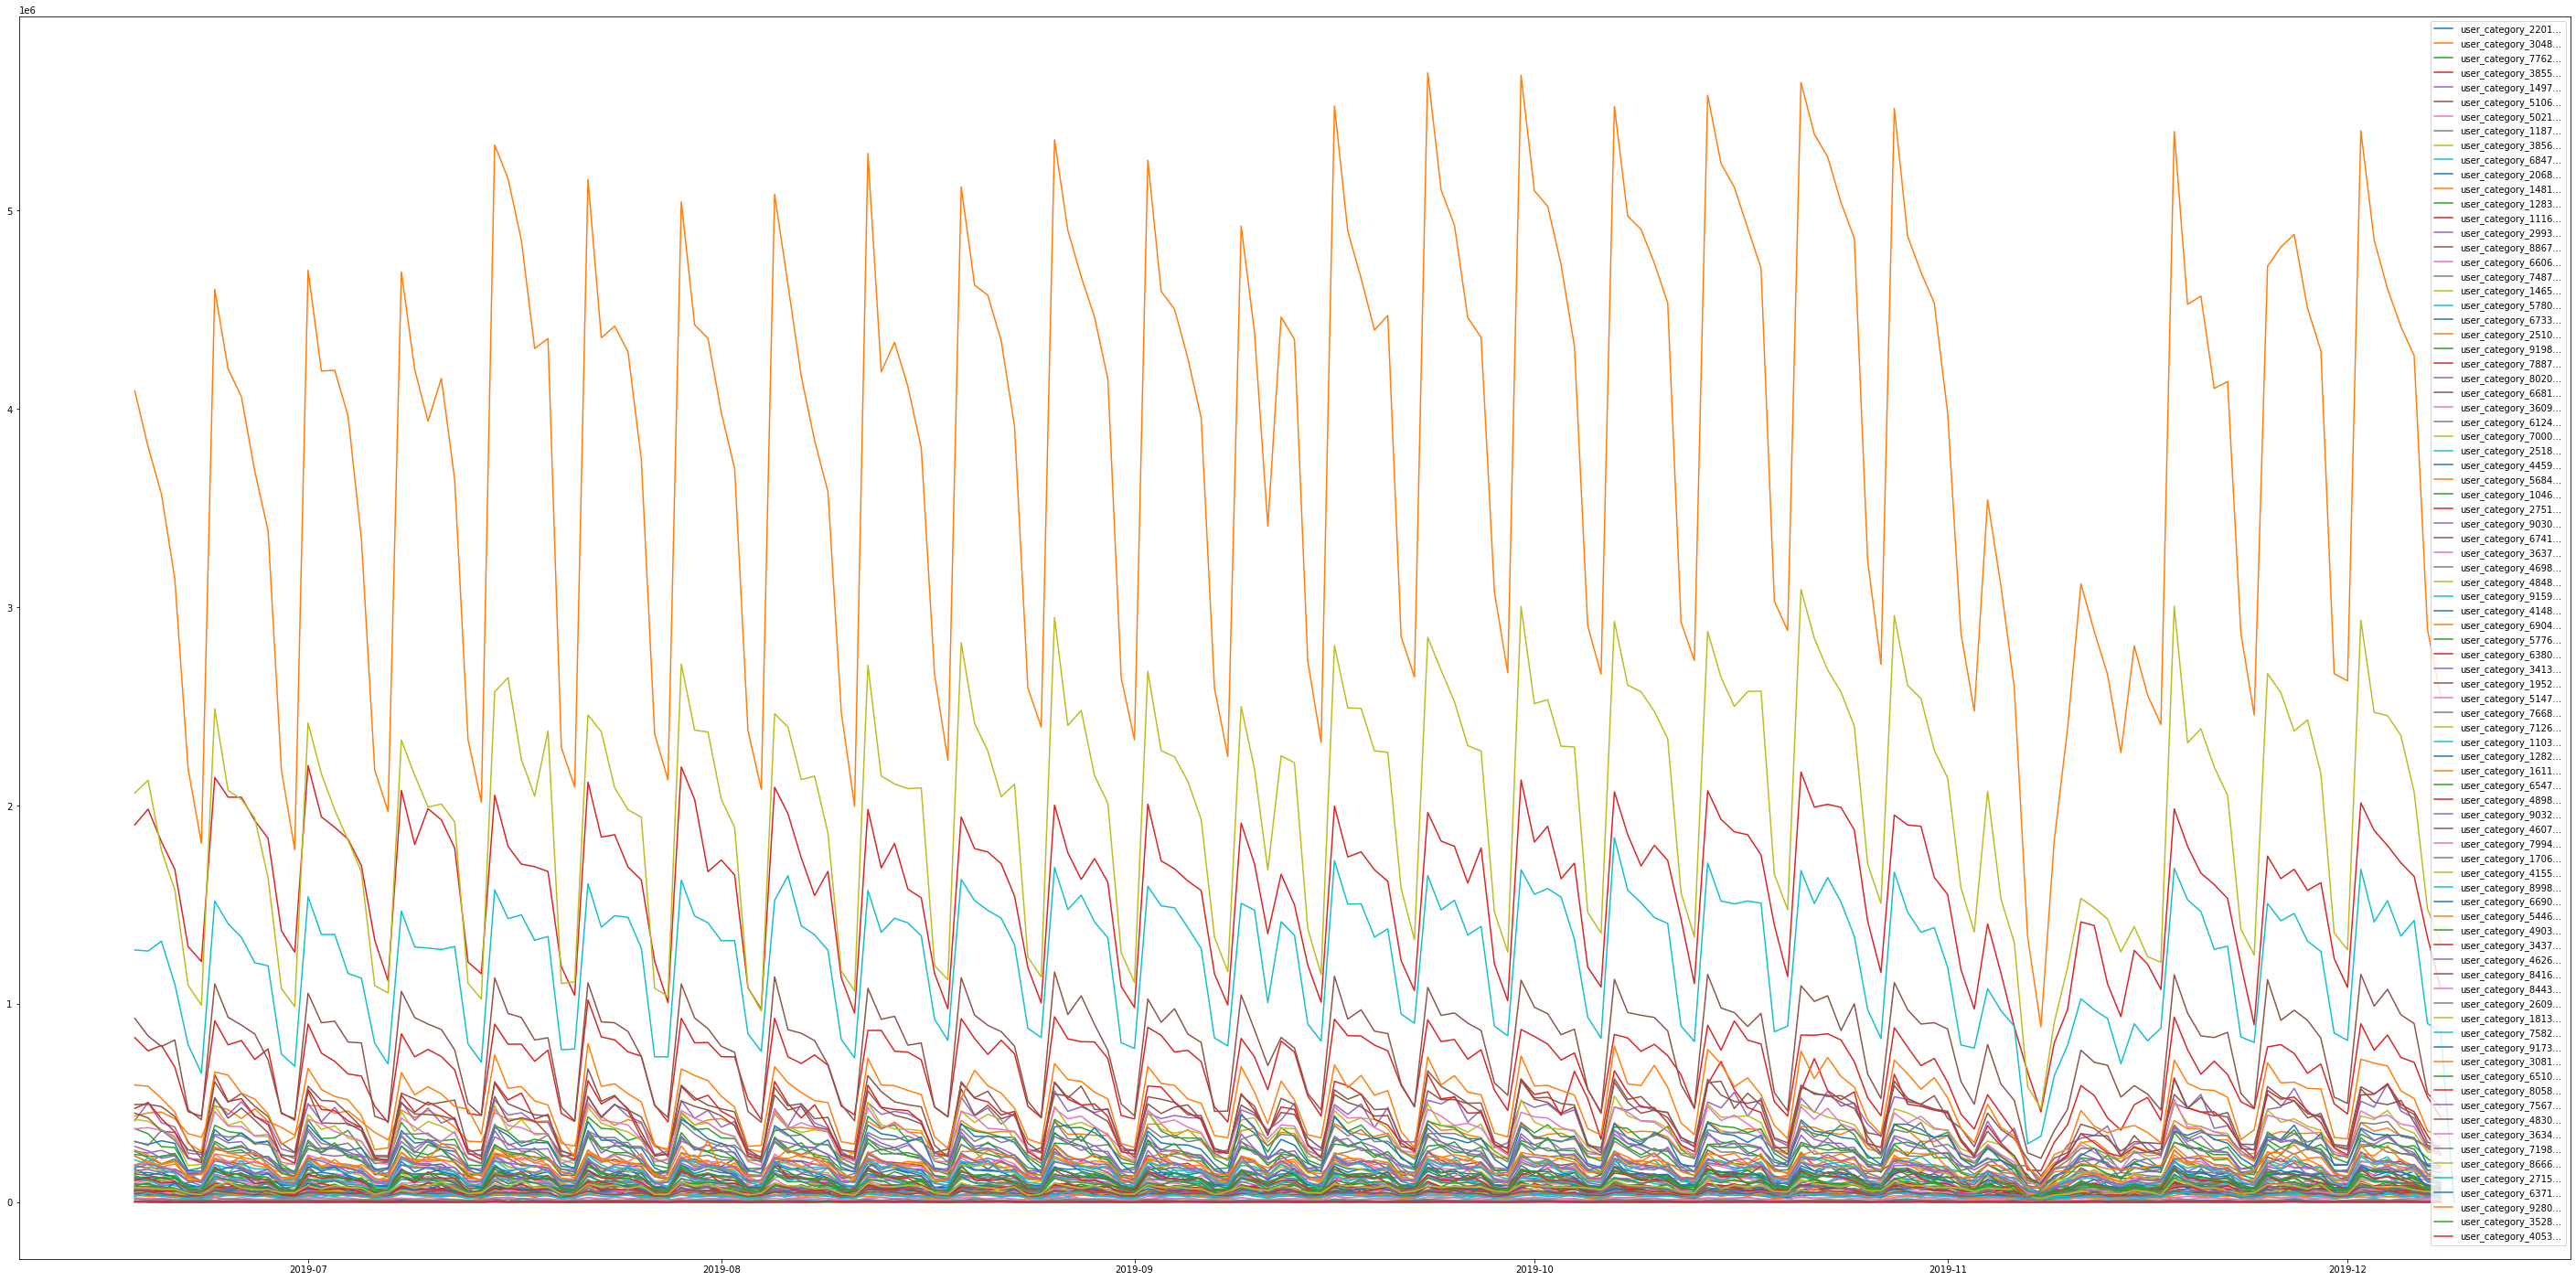

In [10]:
user_region = df.groupby(by=['event_date', 'region']).sum()['revenue_amount'].reset_index('region')

plt.figure(figsize=(50, 25))
for id_region in df.region.unique():
    revenue_region = user_region[user_region.region == id_region]['revenue_amount']
    plt.plot(revenue_region, label=f'user_category_{str(id_region)[:4]}...')
plt.legend()
plt.show()

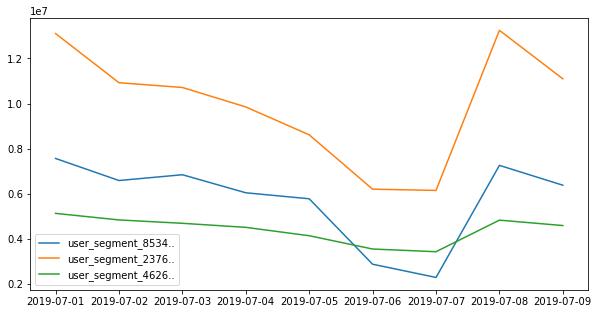

In [11]:
user_segment_week = df.groupby(by=['event_date', 'user_segment']).sum()['revenue_amount'].reset_index()
revenue_user_segment_1 = user_segment_week[user_segment_week.user_segment == 853431062533847667][['event_date', 'revenue_amount']]
revenue_user_segment_1 = revenue_user_segment_1[(revenue_user_segment_1['event_date'] >= '2019-07-01') & (revenue_user_segment_1['event_date'] < '2019-07-10')]
revenue_user_segment_2 = user_segment_week[user_segment_week.user_segment == 2376074197230840906][['event_date', 'revenue_amount']]
revenue_user_segment_2 = revenue_user_segment_2[(revenue_user_segment_2['event_date'] >= '2019-07-01') & (revenue_user_segment_2['event_date'] < '2019-07-10')]
revenue_user_segment_3 = user_segment_week[user_segment_week.user_segment == 4626944681007198896][['event_date', 'revenue_amount']]
revenue_user_segment_3 = revenue_user_segment_3[(revenue_user_segment_3['event_date'] >= '2019-07-01') & (revenue_user_segment_3['event_date'] < '2019-07-10')]
plt.figure(figsize=(10, 5))
plt.plot(revenue_user_segment_1['event_date'], revenue_user_segment_1['revenue_amount'], label='user_segment_8534..')
plt.plot(revenue_user_segment_2['event_date'], revenue_user_segment_2['revenue_amount'], label='user_segment_2376..')
plt.plot(revenue_user_segment_3['event_date'], revenue_user_segment_3['revenue_amount'], label='user_segment_4626..')
plt.legend()
plt.show()

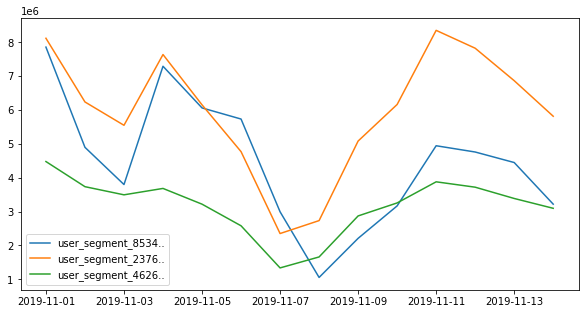

In [12]:
user_segment_week = df.groupby(by=['event_date', 'user_segment']).sum()['revenue_amount'].reset_index()
revenue_user_segment_1 = user_segment_week[user_segment_week.user_segment == 853431062533847667][['event_date', 'revenue_amount']]
revenue_user_segment_1 = revenue_user_segment_1[(revenue_user_segment_1['event_date'] >= '2019-11-01') & (revenue_user_segment_1['event_date'] < '2019-11-15')]
revenue_user_segment_2 = user_segment_week[user_segment_week.user_segment == 2376074197230840906][['event_date', 'revenue_amount']]
revenue_user_segment_2 = revenue_user_segment_2[(revenue_user_segment_2['event_date'] >= '2019-11-01') & (revenue_user_segment_2['event_date'] < '2019-11-15')]
revenue_user_segment_3 = user_segment_week[user_segment_week.user_segment == 4626944681007198896][['event_date', 'revenue_amount']]
revenue_user_segment_3 = revenue_user_segment_3[(revenue_user_segment_3['event_date'] >= '2019-11-01') & (revenue_user_segment_3['event_date'] < '2019-11-15')]
plt.figure(figsize=(10, 5))
plt.plot(revenue_user_segment_1['event_date'], revenue_user_segment_1['revenue_amount'], label='user_segment_8534..')
plt.plot(revenue_user_segment_2['event_date'], revenue_user_segment_2['revenue_amount'], label='user_segment_2376..')
plt.plot(revenue_user_segment_3['event_date'], revenue_user_segment_3['revenue_amount'], label='user_segment_4626..')
plt.legend()
plt.show()

In [13]:
df.groupby(by=['user_segment'])['revenue_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
user_segment,,,,,,,,
853431062533847667,1001507.0,1094.330305,2392.330098,1.0,226.0,489.0,1113.0,288123.0
2376074197230840906,4013951.0,401.615956,571.446013,4.0,109.0,209.0,475.0,52540.0
4626944681007198896,3610384.0,207.760172,285.545686,4.0,63.0,112.0,230.0,19950.0


In [14]:
df.groupby(by=['region'])['revenue_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
68475388295793322,95906.0,289.345317,504.681673,6.0,78.00,134.0,328.0,31816.0
181387893390186210,40756.0,299.629748,461.930430,8.0,70.00,140.0,328.0,13170.0
308194675497345788,22341.0,252.626919,544.986118,6.0,70.00,129.0,280.0,22775.0
385667469633138042,59486.0,272.589534,507.917500,6.0,69.00,132.0,284.0,23471.0
405364780634206711,1040.0,205.209615,295.197711,8.0,63.75,112.0,231.0,5121.0
...,...,...,...,...,...,...,...,...
9030439280442565223,63862.0,241.213507,374.722208,4.0,58.00,116.0,272.0,18971.0
9032475813655386611,75065.0,341.125571,583.562907,6.0,70.00,161.0,391.0,33244.0
9159753098538066161,50486.0,324.889870,721.907652,6.0,90.00,148.0,335.0,33051.0


In [15]:
df.groupby(by=['category'])['revenue_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
57514010642945023,689886.0,347.826167,605.864274,20.0,109.0,167.0,369.0,42271.0
91460430793700892,280512.0,441.861699,651.938097,11.0,112.0,231.0,518.0,41867.0
174490086998335078,379803.0,325.149759,764.813512,1.0,62.0,132.0,291.0,51403.0
264558924403680107,122114.0,509.373364,747.222091,27.0,132.0,279.0,622.0,40908.0
282115902545472456,41960.0,260.778575,354.734991,11.0,84.0,160.0,302.0,15630.0
320230973495659885,80051.0,286.013254,414.997017,6.0,70.0,140.0,329.0,19950.0
1472231361867825698,627129.0,258.353200,594.984151,4.0,56.0,112.0,231.0,30429.0
1560592244484430230,204558.0,313.285665,464.354426,13.0,111.0,167.0,370.0,29030.0
1793067034829450750,344271.0,497.431001,1073.795206,15.0,118.0,244.0,524.0,140792.0


In [16]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) & (data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100 <= 100*share].reset_index()
    return x

# Предсказание MDE

### Если период для оценки MDE на исторических данных взят с 1го июля

In [17]:
for size_group in [0.1, 0.25, 0.5]:
    for amount_days in [30, 60, 90]:
        data = choose_date(df, datetime.datetime(2019, 7, 1, 0, 0), amount_days, size_group)
        mean = data.revenue_amount.mean()
        std = data.revenue_amount.std()
        alpha = 0.01
        power = 0.8
        result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
        for result_effect in np.arange(0.001, 1, 0.001):
            effect_size = (mean / std) * result_effect
            sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
            if sample_vol / data.shape[0] < 1:
                print(f'size_group = {size_group}, amount_days = {amount_days}, result_effect = {result_effect}')
                break

size_group = 0.1, amount_days = 30, result_effect = 0.136
size_group = 0.1, amount_days = 60, result_effect = 0.128
size_group = 0.1, amount_days = 90, result_effect = 0.125
size_group = 0.25, amount_days = 30, result_effect = 0.08700000000000001
size_group = 0.25, amount_days = 60, result_effect = 0.092
size_group = 0.25, amount_days = 90, result_effect = 0.08800000000000001
size_group = 0.5, amount_days = 30, result_effect = 0.058
size_group = 0.5, amount_days = 60, result_effect = 0.059000000000000004
size_group = 0.5, amount_days = 90, result_effect = 0.058


### Если период для оценки MDE на исторических данных взят с 1го сентября (как раз попадает то проседание в revenue)

In [18]:
for size_group in [0.1, 0.25, 0.5]:
    for amount_days in [30, 60, 90]:
        data = choose_date(df, datetime.datetime(2019, 9, 1, 0, 0), amount_days, size_group)
        mean = data.revenue_amount.mean()
        std = data.revenue_amount.std()
        alpha = 0.01
        power = 0.8
        result_effect = 0.04 # целевой размер относительного отклоенения исходной метрики
        for result_effect in np.arange(0.001, 1, 0.001):
            effect_size = (mean / std) * result_effect
            sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
            if sample_vol / data.shape[0] < 1:
                print(f'size_group = {size_group}, amount_days = {amount_days}, result_effect = {result_effect}')
                break

size_group = 0.1, amount_days = 30, result_effect = 0.126
size_group = 0.1, amount_days = 60, result_effect = 0.126
size_group = 0.1, amount_days = 90, result_effect = 0.123
size_group = 0.25, amount_days = 30, result_effect = 0.085
size_group = 0.25, amount_days = 60, result_effect = 0.08700000000000001
size_group = 0.25, amount_days = 90, result_effect = 0.084
size_group = 0.5, amount_days = 30, result_effect = 0.059000000000000004
size_group = 0.5, amount_days = 60, result_effect = 0.061
size_group = 0.5, amount_days = 90, result_effect = 0.060000000000000005


# Исследование CUPED 

In [19]:
def choose_date_modif(data, share):
    x = data[(data.user_id)%100 <= 100*share].reset_index()
    return x

In [20]:
for i in range(6, 12):
    data_pre = df[(df.event_date >= datetime.datetime(2019, i, 1, 0, 0)) & (df.event_date < datetime.datetime(2019, i+1, 1, 0, 0))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
    if i + 2 <= 12:
        print(f'Период теста = {datetime.datetime(2019, i+1, 1, 0, 0)} до {datetime.datetime(2019, i+2, 1, 0, 0)}:')
        data_test = df[(df.event_date >= datetime.datetime(2019, i+1, 1, 0, 0)) & (df.event_date < datetime.datetime(2019, i+2, 1, 0, 0))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
    else:
        print(f'Период теста = {datetime.datetime(2019, i+1, 1, 0, 0)} до {datetime.datetime(2020, 1, 1, 0, 0)}:')
        data_test = df[(df.event_date >= datetime.datetime(2019, i+1, 1, 0, 0)) & (df.event_date < datetime.datetime(2020, 1, 1, 0, 0))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
        
    data_join = data_test.merge(data_pre, left_on='user_id', right_on='user_id', suffixes=('', '_pre'))
    data_join['pre_revenue_average'] = data_join.revenue_amount_pre.mean()
    
    teta = np.cov(data_join.revenue_amount, data_join.revenue_amount_pre, ddof=1)[0][1] / np.var(data_join.revenue_amount_pre, ddof=1)
    #corr = np.corrcoef(data_join.revenue_amount, data_join.revenue_amount_pre)[0][1]
    data_join['cuped_revenue'] = data_join.revenue_amount - teta * (data_join.revenue_amount_pre - data_join.pre_revenue_average)
    
    #mde
    size_group = 0.5
    data = choose_date_modif(data_join, size_group)
    mean_cuped = data.cuped_revenue.mean()
    std_cuped = data.cuped_revenue.std()
    mean = data.revenue_amount.mean()
    std = data.revenue_amount.std()
    alpha = 0.01
    power = 0.8
    result_effect = 0.0 # целевой размер относительного отклоенения исходной метрики
    result_effect_cuped = 0.0
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size_cuped = (mean_cuped / std_cuped) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size_cuped, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            result_effect_cuped = result_effect
            print(f'result_effect_cuped = {result_effect}')
            break
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size = (mean / std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            print(f'result_effect = {result_effect}')
            break
    print(f'Cuped лучше обычной метрики на {result_effect / result_effect_cuped} раза')
#data_join

Период теста = 2019-07-01 00:00:00 до 2019-08-01 00:00:00:
result_effect_cuped = 0.054
result_effect = 0.082
Cuped лучше обычной метрики на 1.5185185185185186 раза
Период теста = 2019-08-01 00:00:00 до 2019-09-01 00:00:00:
result_effect_cuped = 0.039
result_effect = 0.079
Cuped лучше обычной метрики на 2.0256410256410255 раза
Период теста = 2019-09-01 00:00:00 до 2019-10-01 00:00:00:
result_effect_cuped = 0.033
result_effect = 0.074
Cuped лучше обычной метрики на 2.242424242424242 раза
Период теста = 2019-10-01 00:00:00 до 2019-11-01 00:00:00:
result_effect_cuped = 0.032
result_effect = 0.08
Cuped лучше обычной метрики на 2.5 раза
Период теста = 2019-11-01 00:00:00 до 2019-12-01 00:00:00:
result_effect_cuped = 0.035
result_effect = 0.075
Cuped лучше обычной метрики на 2.142857142857143 раза
Период теста = 2019-12-01 00:00:00 до 2020-01-01 00:00:00:
result_effect_cuped = 0.036000000000000004
result_effect = 0.067
Cuped лучше обычной метрики на 1.861111111111111 раза


_MDE_ ~ в 2 раза лучше при __cuped__, чем без него. В случае выбора данных за периода в 30 дней перед 30 дневным периодом сбора основной выборки и для выборок 50/50%, видно, что осенью MDE при __cuped__ больше всего отличается от обычной метрики, чем за период лета, начала зимы

### Период теста: 2019-10-01 00:00:00 до 2019-11-01 00:00:00. Насколько сможем снизить MDE?

In [21]:
for i in range(1, 40):
    start_date = datetime.datetime(2019, 10, 1, 0, 0)
    data_pre = df[(df.event_date >= start_date - datetime.timedelta(days=i)) & (df.event_date < start_date)].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
    print(f'Количество дней до теста, которые будем использовать для расчёта CUPED метрики: {i}')
    data_test = df[(df.event_date >= start_date) & (df.event_date < datetime.datetime(2019, 11, 1, 0, 0))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
        
    data_join = data_test.merge(data_pre, left_on='user_id', right_on='user_id', suffixes=('', '_pre'))
    data_join['pre_revenue_average'] = data_join.revenue_amount_pre.mean()
    
    teta = np.cov(data_join.revenue_amount, data_join.revenue_amount_pre, ddof=1)[0][1] / np.var(data_join.revenue_amount_pre, ddof=1)
    #corr = np.corrcoef(data_join.revenue_amount, data_join.revenue_amount_pre)[0][1]
    data_join['cuped_revenue'] = data_join.revenue_amount - teta * (data_join.revenue_amount_pre - data_join.pre_revenue_average)
    #print(f'corr = {corr}')
    #mde
    size_group = 0.5
    data = choose_date_modif(data_join, size_group)
    mean_cuped = data.cuped_revenue.mean()
    std_cuped = data.cuped_revenue.std()
    mean = data.revenue_amount.mean()
    std = data.revenue_amount.std()
    alpha = 0.01
    power = 0.8
    result_effect = 0.0 # целевой размер относительного отклоенения исходной метрики
    result_effect_cuped = 0.0
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size_cuped = (mean_cuped / std_cuped) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size_cuped, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            result_effect_cuped = result_effect
            print(f'result_effect_cuped = {result_effect}')
            break
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size = (mean / std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            #print(f'result_effect = {result_effect}')
            break
    print(f'Cuped лучше обычной метрики на {result_effect / result_effect_cuped} раза')

Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 1
result_effect_cuped = 0.108
Cuped лучше обычной метрики на 1.5092592592592593 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 2
result_effect_cuped = 0.085
Cuped лучше обычной метрики на 1.6823529411764706 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 3
result_effect_cuped = 0.07200000000000001
Cuped лучше обычной метрики на 1.8055555555555554 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 4
result_effect_cuped = 0.060000000000000005
Cuped лучше обычной метрики на 1.95 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 5
result_effect_cuped = 0.053000000000000005
Cuped лучше обычной метрики на 2.0566037735849054 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 6
result_effect_cuped = 0.048
Cuped лучше обычной метрики на 2.12

__Заметим, что MDE получилось улучшить, если собирать данные за 32-36 дней до тестирования в 30 дней.__
### Теперь проверим, как зависит MDE от регулирования количества дней для расчёта cuped и количества дней теста.

In [22]:
for i in range(1, 31):
    start_date = datetime.datetime(2019, 10, 1, 0, 0)
    data_pre = df[(df.event_date >= start_date - datetime.timedelta(days=i)) & (df.event_date < start_date)].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
    print(f'Количество дней до теста, которые будем использовать для расчёта CUPED метрики: {i}. Количество дней теста: {i}')
    data_test = df[(df.event_date >= start_date) & (df.event_date < start_date + datetime.timedelta(days=i))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
        
    data_join = data_test.merge(data_pre, left_on='user_id', right_on='user_id', suffixes=('', '_pre'))
    data_join['pre_revenue_average'] = data_join.revenue_amount_pre.mean()
    
    teta = np.cov(data_join.revenue_amount, data_join.revenue_amount_pre, ddof=1)[0][1] / np.var(data_join.revenue_amount_pre, ddof=1)
    corr = np.corrcoef(data_join.revenue_amount, data_join.revenue_amount_pre)[0][1]
    data_join['cuped_revenue'] = data_join.revenue_amount - teta * (data_join.revenue_amount_pre - data_join.pre_revenue_average)
    print(f'corr = {corr}')
    #mde
    size_group = 0.5
    data = choose_date_modif(data_join, size_group)
    mean_cuped = data.cuped_revenue.mean()
    std_cuped = data.cuped_revenue.std()
    mean = data.revenue_amount.mean()
    std = data.revenue_amount.std()
    alpha = 0.01
    power = 0.8
    result_effect = 0.0 # целевой размер относительного отклоенения исходной метрики
    result_effect_cuped = 0.0
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size_cuped = (mean_cuped / std_cuped) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size_cuped, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            result_effect_cuped = result_effect
            print(f'result_effect_cuped = {result_effect}')
            break
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size = (mean / std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            print(f'result_effect = {result_effect}')
            break
    print(f'Cuped лучше обычной метрики на {result_effect / result_effect_cuped} раза')

Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 1. Количество дней теста: 1
corr = 0.6833742259433868
result_effect_cuped = 0.131
result_effect = 0.195
Cuped лучше обычной метрики на 1.4885496183206106 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 2. Количество дней теста: 2
corr = 0.7696955227482616
result_effect_cuped = 0.101
result_effect = 0.165
Cuped лучше обычной метрики на 1.6336633663366336 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 3. Количество дней теста: 3
corr = 0.7890768389193341
result_effect_cuped = 0.094
result_effect = 0.151
Cuped лучше обычной метрики на 1.6063829787234043 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 4. Количество дней теста: 4
corr = 0.7556951254327368
result_effect_cuped = 0.075
result_effect = 0.137
Cuped лучше обычной метрики на 1.8266666666666669 раза
Количество дней до теста, которые будем испо

__Видим, что если проводить тестирование 15 дней и собирать данные за 15 дней до этого, то мы достигаем макс. разницы в MDE. И макс. значения корреляции между данными.__

### Теперь зафиксируем количество дней теста в 15 дней. И поисследуем, как MDE меняется для них:

In [23]:
for i in range(1, 31):
    start_date = datetime.datetime(2019, 10, 1, 0, 0)
    data_pre = df[(df.event_date >= start_date - datetime.timedelta(days=i)) & (df.event_date < start_date)].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
    print(f'Количество дней до теста, которые будем использовать для расчёта CUPED метрики: {i}.')
    data_test = df[(df.event_date >= start_date) & (df.event_date < start_date + datetime.timedelta(days=15))].groupby(by='user_id').sum().reset_index()[['user_id', 'revenue_amount']]
        
    data_join = data_test.merge(data_pre, left_on='user_id', right_on='user_id', suffixes=('', '_pre'))
    data_join['pre_revenue_average'] = data_join.revenue_amount_pre.mean()
    
    teta = np.cov(data_join.revenue_amount, data_join.revenue_amount_pre, ddof=1)[0][1] / np.var(data_join.revenue_amount_pre, ddof=1)
    corr = np.corrcoef(data_join.revenue_amount, data_join.revenue_amount_pre)[0][1]
    data_join['cuped_revenue'] = data_join.revenue_amount - teta * (data_join.revenue_amount_pre - data_join.pre_revenue_average)
    print(f'corr = {corr}')
    #mde
    size_group = 0.5
    data = choose_date_modif(data_join, size_group)
    mean_cuped = data.cuped_revenue.mean()
    std_cuped = data.cuped_revenue.std()
    mean = data.revenue_amount.mean()
    std = data.revenue_amount.std()
    alpha = 0.01
    power = 0.8
    result_effect = 0.0 # целевой размер относительного отклоенения исходной метрики
    result_effect_cuped = 0.0
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size_cuped = (mean_cuped / std_cuped) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size_cuped, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            result_effect_cuped = result_effect
            print(f'result_effect_cuped = {result_effect}')
            break
    for result_effect in np.arange(0.001, 1, 0.001):
        effect_size = (mean / std) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data.shape[0] < 1:
            print(f'result_effect = {result_effect}')
            break
    print(f'Cuped лучше обычной метрики на {result_effect / result_effect_cuped} раза')

Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 1.
corr = 0.6784333481366699
result_effect_cuped = 0.101
result_effect = 0.161
Cuped лучше обычной метрики на 1.594059405940594 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 2.
corr = 0.7563717604373198
result_effect_cuped = 0.076
result_effect = 0.14
Cuped лучше обычной метрики на 1.842105263157895 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 3.
corr = 0.8378992919122887
result_effect_cuped = 0.064
result_effect = 0.128
Cuped лучше обычной метрики на 2.0 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 4.
corr = 0.8509649944347852
result_effect_cuped = 0.054
result_effect = 0.115
Cuped лучше обычной метрики на 2.1296296296296298 раза
Количество дней до теста, которые будем использовать для расчёта CUPED метрики: 5.
corr = 0.8665368673715045
result_effect_cuped = 0.048
result_effect = 0.107
Cup

__Видим, что MDE улучшается с ростом дней сбора данных для расчёта CUPED метрики, начиная с 15го дня (т.е., если количество дней сбора данных, больше, чем количество дней тестирования) и достигает макс. в разницы с обычной метрикой на 29-30 день__

## Стратификация

In [24]:
for strat in ['user_segment', 'category', 'region']:
    strata_p = df[[strat,'revenue_amount']].groupby([strat]).count() / df.count()[0]
    data_test = df.join(strata_p, on=strat, rsuffix='_probality')
    mean_strat = (data_test.groupby([strat]).mean().revenue_amount * data_test.groupby([strat]).mean().revenue_amount_probality).sum()
    mean_data = df.revenue_amount.mean()
    std_strat = (data_test.groupby([strat]).var().revenue_amount *
                data_test.groupby([strat]).mean().revenue_amount_probality).sum() / data_test.count()[0]
    std_data = data_test.revenue_amount.var() / data_test.count()[0]
    print(f'Страта = {strat}, mean_strat = {mean_strat}, var_strat = {std_strat}, var_data = {std_data}')

Страта = user_segment, mean_strat = 400.9046571917269, var_strat = 0.0986088138862044, var_data = 0.10689110614709409
Страта = category, mean_strat = 400.90465719172687, var_strat = 0.10282401734059139, var_data = 0.10689110614709409
Страта = region, mean_strat = 400.904657191727, var_strat = 0.10431380040160064, var_data = 0.10689110614709409


In [25]:
def choose_date_strat(data, strat, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) & (data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id', strat]).sum().reset_index()
    x = tmp[(tmp.user_id)%100 <= 100*share].reset_index()
    return x

In [26]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) & (data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id', strat]).sum().reset_index()
    x = tmp[(tmp.user_id)%100 <= 100*share].reset_index()
    return x

In [27]:
for strat in ['user_segment', 'category', 'region']:
    
    data_test = choose_date(df, datetime.datetime(2019, 10, 1, 0, 0), 30, 0.5)
    mean_data = data_test.revenue_amount.mean()
    std_data = data_test.revenue_amount.var() / data_test.count()[0]
    
    data_test = choose_date_strat(df, strat, datetime.datetime(2019, 10, 1, 0, 0), 30, 0.5)
    #print(data_test[[strat,'revenue_amount']].groupby([strat]).count() / data_test.count()[0])
    strata_p = data_test[[strat,'revenue_amount']].groupby([strat]).count() / data_test.count()[0]
    data_test = data_test.join(strata_p, on=strat, rsuffix='_probality')
    
    mean_strat = (data_test.groupby([strat]).mean().revenue_amount * data_test.groupby([strat]).mean().revenue_amount_probality).sum()
    std_strat = (data_test.groupby([strat]).var().revenue_amount *
                data_test.groupby([strat]).mean().revenue_amount_probality).sum() / data_test.count()[0]
    
    #MDE
    alpha = 0.01
    power = 0.8
    result_effect = 0.0 # целевой размер относительного отклоенения исходной метрики
    result_effect_strat = 0.0
    print(f'Исследование изменения MDE для страты = {strat}, для теста 50/50% длительностью 30 дней')
    for result_effect in np.arange(0.000001, 1, 0.000001):
        effect_size_start = (mean_strat / std_strat) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size_start, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data_test.shape[0] < 1:
            result_effect_strat = result_effect
            print(f'result_effect_strat = {result_effect}')
            break
    for result_effect in np.arange(0.000001, 1, 0.000001):
        effect_size = (mean_data / std_data) * result_effect
        sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative='two-sided')    
        if sample_vol / data_test.shape[0] < 1:
            print(f'result_effect = {result_effect}')
            break
    print(f'Strat лучше обычной метрики на {result_effect / result_effect_strat} раза')

Исследование изменения MDE для страты = user_segment, для теста 50/50% длительностью 30 дней
result_effect_strat = 0.0012809999999999998
result_effect = 0.00139
Strat лучше обычной метрики на 1.0850897736143639 раза
Исследование изменения MDE для страты = category, для теста 50/50% длительностью 30 дней
result_effect_strat = 0.0011469999999999998
result_effect = 0.0011569999999999998
Strat лучше обычной метрики на 1.00871839581517 раза
Исследование изменения MDE для страты = region, для теста 50/50% длительностью 30 дней
result_effect_strat = 0.00086
result_effect = 0.0008629999999999999
Strat лучше обычной метрики на 1.0034883720930232 раза


__Приемлемого улучшения MDE мною не замечено__